In [1]:
import pandas as pd
import numpy as np
import json, time, requests, os
from sodapy import Socrata
import missingno as msno
import matplotlib.pyplot as plt
# from h3 import h3
import geopandas as gpd
from geojson import Point, Feature, FeatureCollection, dump, MultiPolygon

# create a PING noise to let you know modeling is done
from IPython.display import Audio
sound_file = 'glass_ping-Go445-1207030150.mp3'
play_sound = Audio(sound_file, autoplay=True)

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Ride-Share

In [2]:
def get_community_boundaries(*args):
    
    if os.path.exists('community_boundaries.pickle'):
        print('loading pickle!')
        community_boundaries = pd.read_pickle('community_boundaries.pickle')
        
    else:
        print('calling API!')
    
        url = 'https://data.cityofchicago.org/resource/igwz-8jzy.json'

        community_boundaries = requests.get(url).json()

        community_boundaries = pd.DataFrame.from_records(community_boundaries)
    
    return community_boundaries

In [3]:
community_boundaries = get_community_boundaries()

loading pickle!


In [4]:
community_boundaries.to_pickle('community_boundaries.pickle')

In [5]:
def get_tract_boundaries(*args):
    
    if os.path.exists('tract_boundaries.pickle'):
        print('loading pickle!')
        tract_boundaries = pd.read_pickle('tract_boundaries.pickle')
        
    else:
        print('calling API!')
        
        url = 'https://data.cityofchicago.org/resource/74p9-q2aq.json'

        tract_boundaries = requests.get(url).json()

        tract_boundaries = pd.DataFrame.from_records(tract_boundaries)
    
    return tract_boundaries

In [6]:
tract_boundaries = get_tract_boundaries()

loading pickle!


In [7]:
tract_boundaries.to_pickle('tract_boundaries.pickle')

In [8]:
def get_tract_rides(*args):
    
    '''
    to gather a dataframe grouped by date, and census tracts 
    '''
    
    if os.path.exists('tract_df.pickle'):
        print('loading pickle!')
        tract_df = pd.read_pickle('tract_df.pickle')
        
    else:
        print('Calling API!')
        
        url = 'https://data.cityofchicago.org/resource/74p9-q2aq.json'
    
        select = 'date_trunc_ymd(trip_start_timestamp) as date,\
        pickup_census_tract,\
        dropoff_census_tract,\
        SUM(trip_total) as total_fare,\
        AVG(trip_total) as avg_fare,\
        SUM(trip_miles) as total_miles,\
        AVG(trip_miles) as avg_trip_mile,\
        COUNT(trip_id) as rides'

        group = 'date,\
        pickup_census_tract,\
        dropoff_census_tract'

        limit = '1000000'
#         where = 'date > "2018-11-20"'
#         where = "date between '2018-11-20T00:00:00' and '2019-04-31T00:00:00'"
#         where=date between '2015-01-10T12:00:00' and '2015-01-10T14:00:00'

        url = 'https://data.cityofchicago.org/resource/m6dm-c72p.json?'

        params = {'$select': select,
                  '$group': group,
                  '$limit': limit}
#                   '$where': where

        tract_df = requests.get(url, params=params)

        tract_df = pd.DataFrame(tract_df)
    
    return tract_df

In [9]:
%time tract_df = get_tract_rides()

loading pickle!
CPU times: user 763 ms, sys: 208 ms, total: 971 ms
Wall time: 980 ms


In [10]:
tract_df.to_pickle('tract_df.pickle')

In [11]:
tract_df['date'] = pd.to_datetime(tract_df['date'])

In [12]:
tract_df['total_fare'] = tract_df['total_fare'].astype('float32')
tract_df['rides'] = tract_df['rides'].astype('float32')

,date,pickup_census_tract,dropoff_census_tract,total_fare,avg_fare,total_miles,avg_trip_mile,rides
0,2018-11-01,17031010100,17031010100,80.000000,26.6666666666666667,43.89345473582128,14.6311515786070933,3.0
1,2018-11-01,17031010100,17031010201,10.000000,5.0000000000000000,2.47236962200484,1.23618481100242000000,2.0
2,2018-11-01,17031010100,17031010202,10.000000,5.0000000000000000,1.38390529514413,0.69195264757206500000,2.0
3,2018-11-01,17031010100,17031010300,7.500000,3.7500000000000000,1.29507338838563,0.64753669419281500000,2.0
4,2018-11-01,17031010100,17031010400,22.500000,7.5000000000000000,4.97527427801646,1.6584247593388200,3.0
...,...,...,...,...,...,...,...,...
999995,2018-11-20,17031241500,17031310500,7.500000,7.5000000000000000,4.8347173088,4.8347173088000000,1.0
999996,2018-11-20,17031241500,17031310600,27.500000,13.7500000000000000,9.13441148005547,4.5672057400277350,2.0
999997,2018-11-20,17031241500,17031310800,20.000000,20.0000000000000000,4.36648650621362,4.3664865062136200,1.0
999998,2018-11-20,17031241500,17031310900,25.000000,12.5000000000000000,11.68419164832756,5.8420958241637800,2.0


In [13]:
tract_df.date = tract_df.date.map(lambda x: x.isoformat())

In [14]:
tract_df = tract_df.groupby(['date','pickup_census_tract']).agg({'total_fare':'sum', 'rides':'sum'}).reset_index()

In [15]:
to_keep = ['date', 'pickup_census_tract', 'total_fare', 'avg_fare', 'total_miles', 'avg_trip_mile', 'rides', 'dropoff_census_tract']
tract_df.merge(tract_boundaries[['geoid10','the_geom']], how='left', left_on='pickup_census_tract', right_on='geoid10').drop(columns=['geoid10'])

,date,pickup_census_tract,total_fare,rides,the_geom
0,2018-11-01T00:00:00,17031010100,1970.459961,126.0,"{'type': 'MultiPolygon', 'coordinates': [[[[-8..."
1,2018-11-01T00:00:00,17031010201,2251.949951,174.0,"{'type': 'MultiPolygon', 'coordinates': [[[[-8..."
2,2018-11-01T00:00:00,17031010202,1351.199951,113.0,"{'type': 'MultiPolygon', 'coordinates': [[[[-8..."
3,2018-11-01T00:00:00,17031010300,2765.659912,201.0,"{'type': 'MultiPolygon', 'coordinates': [[[[-8..."
4,2018-11-01T00:00:00,17031010400,4951.890137,311.0,"{'type': 'MultiPolygon', 'coordinates': [[[[-8..."
...,...,...,...,...,...
15038,2018-11-20T00:00:00,17031241100,4558.069824,414.0,"{'type': 'MultiPolygon', 'coordinates': [[[[-8..."
15039,2018-11-20T00:00:00,17031241200,2412.959961,178.0,"{'type': 'MultiPolygon', 'coordinates': [[[[-8..."
15040,2018-11-20T00:00:00,17031241300,2462.080078,201.0,"{'type': 'MultiPolygon', 'coordinates': [[[[-8..."
15041,2018-11-20T00:00:00,17031241400,15155.690430,1378.0,"{'type': 'MultiPolygon', 'coordinates': [[[[-8..."


In [16]:
tract_boundaries.to_pickle('tract_boundaries.pickle')

In [17]:
def get_community_rides(*args):
    
    if os.path.exists('community_df.pickle'):
        print('loading pickle!')
        community_df = pd.read_pickle('community_df.pickle')
    else:
        print('calling API')
    
        select = 'date_trunc_ymd(trip_start_timestamp) as date,\
        date_extract_hh(trip_start_timestamp) as hour,\
        pickup_community_area,\
        dropoff_community_area,\
        SUM(trip_total) as total_fare,\
        AVG(trip_total) as avg_fare,\
        SUM(trip_miles) as total_miles,\
        AVG(trip_miles) as avg_trip_mile,\
        COUNT(trip_id) as rides'

        group = 'date,hour,\
        pickup_community_area,\
        dropoff_community_area'

        limit = '10000000'
        where = 'date > "2018-01-01"'

        url = 'https://data.cityofchicago.org/resource/m6dm-c72p.json?'

        params = {'$select': select,
                  '$group': group,
                  '$limit': limit,
                  '$where': where}

        community_df = requests.get(url, params=params).json()

        community_df = pd.DataFrame(df)
    
    return community_df

In [544]:
community_df = get_community_rides()

loading pickle!


In [545]:
community_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000000 entries, 0 to 9999999
Data columns (total 9 columns):
 #   Column                  Dtype         
---  ------                  -----         
 0   date                    datetime64[ns]
 1   hour                    int16         
 2   pickup_community_area   float16       
 3   dropoff_community_area  float16       
 4   total_fare              float32       
 5   avg_fare                float32       
 6   total_miles             float32       
 7   avg_trip_mile           float32       
 8   rides                   int16         
dtypes: datetime64[ns](1), float16(2), float32(4), int16(2)
memory usage: 305.2 MB


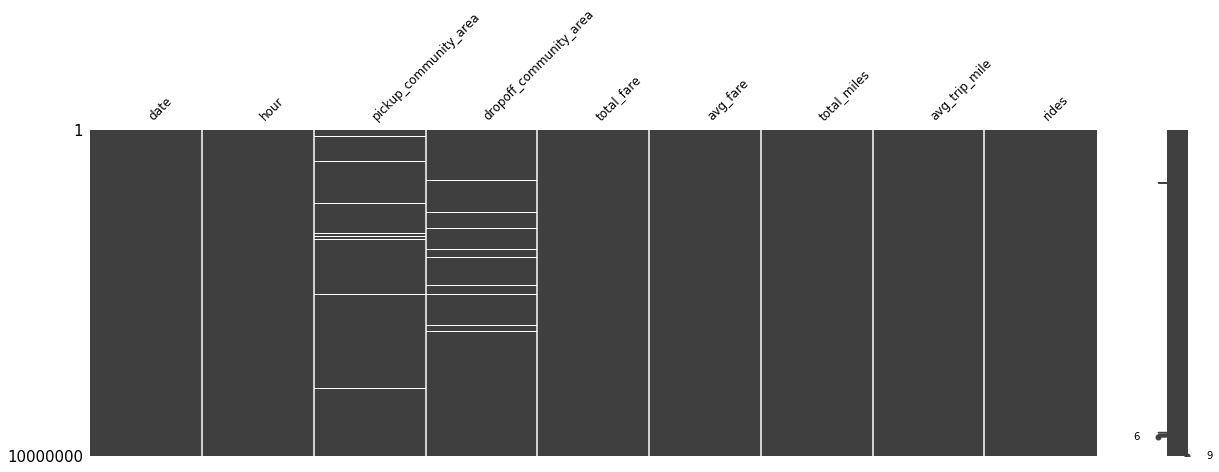

In [546]:
msno.matrix(community_df, figsize=(20, 6), fontsize=12);

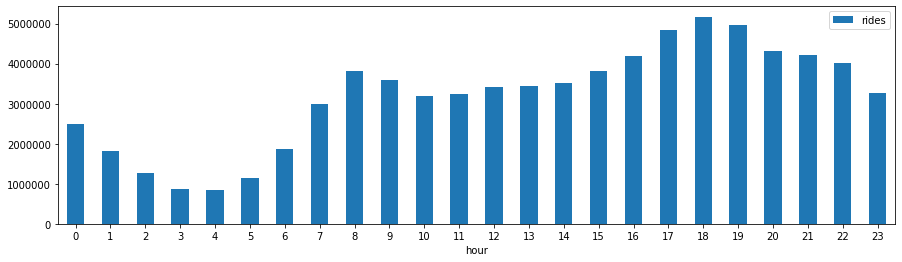

In [547]:
community_df.groupby('hour').agg({'rides':'sum'}).plot(kind='bar', figsize=(15, 4),)
plt.xticks(rotation=0);

In [548]:
community_df['date_time'] = community_df.apply(lambda row: row['date'] + pd.to_timedelta(row['hour'], unit='h'), axis=1)

In [552]:
community_df

,date,hour,pickup_community_area,dropoff_community_area,total_fare,avg_fare,total_miles,avg_trip_mile,rides,date_time
0,2018-11-01,0,1.0,1.0,120.500000,6.342105,17.498251,0.920961,19,2018-11-01
1,2018-11-01,0,1.0,2.0,25.500000,8.500000,5.520261,1.840087,3,2018-11-01
2,2018-11-01,0,1.0,3.0,72.300003,12.050000,22.148273,3.691379,6,2018-11-01
3,2018-11-01,0,1.0,4.0,10.000000,10.000000,3.056188,3.056188,1,2018-11-01
4,2018-11-01,0,1.0,6.0,131.000000,14.555555,52.517239,5.835249,9,2018-11-01
...,...,...,...,...,...,...,...,...,...,...
9999995,2019-07-12,0,21.0,20.0,22.049999,11.025000,6.069338,3.034669,2,2019-07-12
9999996,2019-07-12,0,21.0,21.0,48.400002,6.914286,5.819068,0.831295,7,2019-07-12
9999997,2019-07-12,0,21.0,22.0,128.800003,8.050000,29.174320,1.823395,16,2019-07-12
9999998,2019-07-12,0,21.0,24.0,126.220001,11.474545,39.676201,3.606927,11,2019-07-12


In [568]:
hour_group = community_df.groupby(['date_time','pickup_community_area']).agg({'rides': 'sum'}).reset_index()

In [569]:
hour_group[(hour_group['date_time'] > '11-17-18') & (hour_group['date_time'] < '11-25-18')].to_pickle('hour_test.pickle')

In [58]:
community_df['same_comm'] = community_df.apply(lambda row: np.where(row['pickup_community_area'] == row['dropoff_community_area'], 1,0), axis=1)

In [185]:
total = community_df['rides'].sum()
same_community = community_df.groupby('same_comm').agg({'rides':'sum'})
same_community = (same_community / total) * 100

xticks = np.linspace(0,90,10)
xlabels = [f'{int(x)}%' for x in xticks]

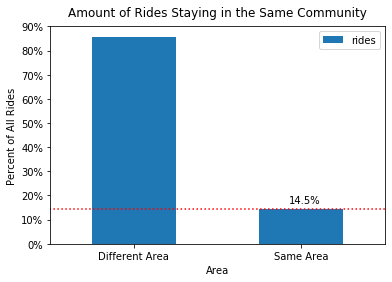

In [192]:
same_community.plot(kind='bar')
plt.hlines(same_community.rides[1], -2,2, linestyles='dotted', color='red')
plt.text(.925,17, '14.5%')
plt.xticks(ticks=[0,1], labels=['different area'.title(), 'same area'.title()], rotation=0)
plt.xlabel('Area')
plt.yticks(ticks=xticks, labels=xlabels)
plt.ylabel('Percent of All Rides')
plt.title('Amount of Rides Staying in the Same Community',
          pad=10);

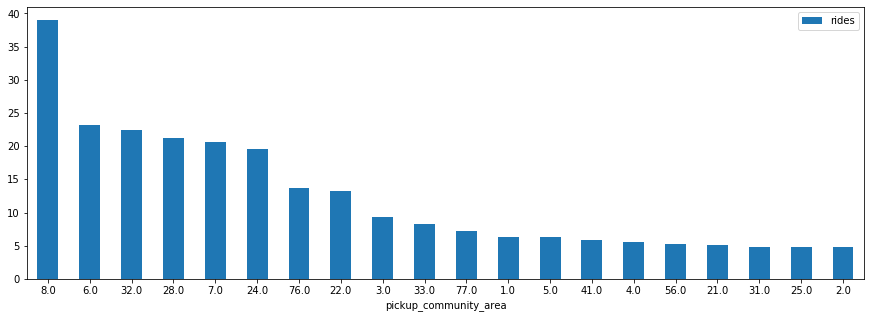

In [22]:
community_df.groupby('pickup_community_area')\
.agg({'rides':'mean'}).sort_values('rides', ascending=False).head(20).plot(kind='bar', figsize=(15,5))
plt.xticks(rotation=0);

In [23]:
area_8 = community_df[community_df['pickup_community_area'] == 8]

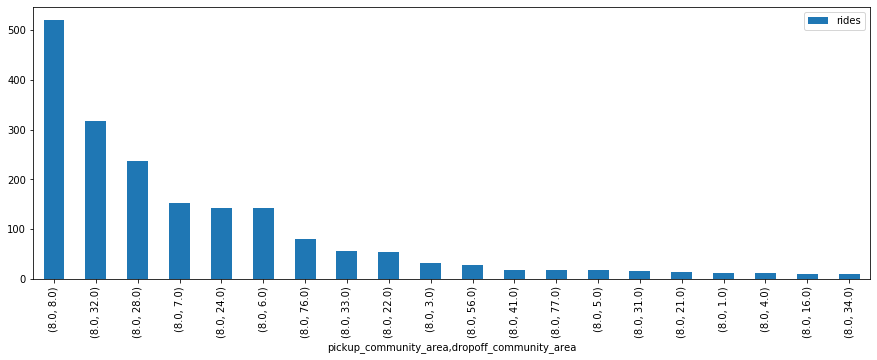

In [24]:
area_8.groupby(['pickup_community_area', 'dropoff_community_area'])\
.agg({'rides':'mean'}).sort_values('rides', ascending=False).head(20).plot(kind='bar', figsize=(15,5))

In [455]:
community_df['dow'] = community_df['date'].dt.day_name()

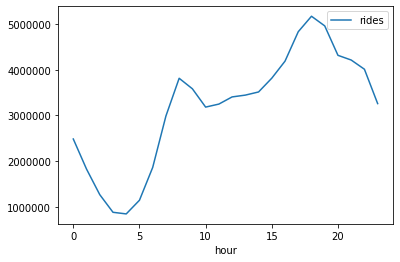

In [466]:
community_df.groupby('hour').agg({'rides':'sum'}).plot()

In [469]:
import seaborn as sns

In [ ]:
sns.lineplot()

In [475]:
def plot_dow():
    
    fig = plt.figure()
    ax1 = fig.add_subplot(111)

    ax1.p(x[:4], y[:4], s=10, c='b', marker="s", label='first')
    ax1.scatter(x[40:],y[40:], s=10, c='r', marker="o", label='second')
    plt.legend(loc='upper left');
    
    
    for x in community_df['dow'].unique():
        df = community_df[community_df['dow'] == x]
        df = df.groupby('hour').agg({'rides':'sum'}).plot()
        ax1.plot(df.index, df['rides'], label=x)
        
    return plt.show()

In [505]:
community_df[''] = community_df['date'].dt.dayofweek

In [508]:
community_df[''] = community_df[''].map(lambda x: np.where(x>5,'Weekend', 'Weekday'))

In [509]:
community_df

,date,hour,pickup_community_area,dropoff_community_area,total_fare,avg_fare,total_miles,avg_trip_mile,rides,same_comm,dow,
0,2018-11-01,0,1.0,1.0,120.500000,6.342105,17.498251,0.920961,19,1,Thursday,Weekday
1,2018-11-01,0,1.0,2.0,25.500000,8.500000,5.520261,1.840087,3,0,Thursday,Weekday
2,2018-11-01,0,1.0,3.0,72.300003,12.050000,22.148273,3.691379,6,0,Thursday,Weekday
3,2018-11-01,0,1.0,4.0,10.000000,10.000000,3.056188,3.056188,1,0,Thursday,Weekday
4,2018-11-01,0,1.0,6.0,131.000000,14.555555,52.517239,5.835249,9,0,Thursday,Weekday
...,...,...,...,...,...,...,...,...,...,...,...,...
9999995,2019-07-12,0,21.0,20.0,22.049999,11.025000,6.069338,3.034669,2,0,Friday,Weekday
9999996,2019-07-12,0,21.0,21.0,48.400002,6.914286,5.819068,0.831295,7,1,Friday,Weekday
9999997,2019-07-12,0,21.0,22.0,128.800003,8.050000,29.174320,1.823395,16,0,Friday,Weekday
9999998,2019-07-12,0,21.0,24.0,126.220001,11.474545,39.676201,3.606927,11,0,Friday,Weekday


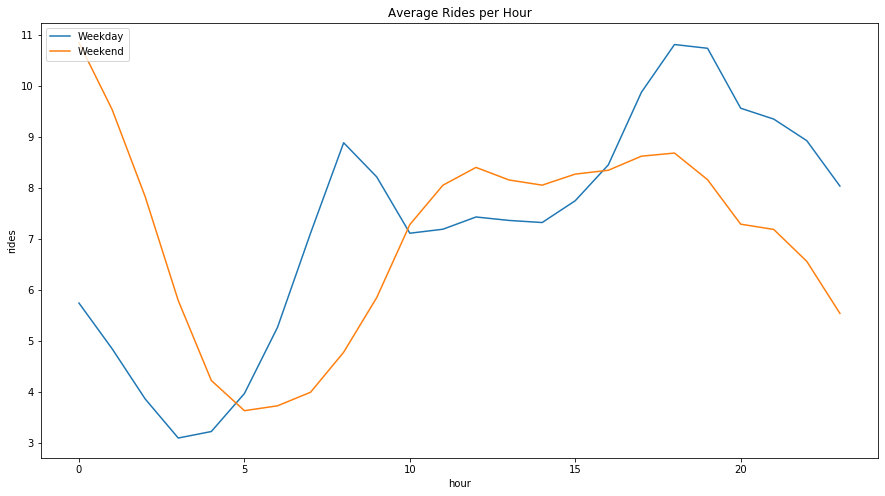

In [539]:
groups = community_df.groupby(['hour','']).agg({'rides':'mean'}).reset_index()

plt.figure(figsize=(15,8))
plt.title('Average Rides per Hour')
sns.lineplot(groups['hour'], groups['rides'], data=groups, hue=groups[''])
plt.legend(loc='upper left')
plt.title;

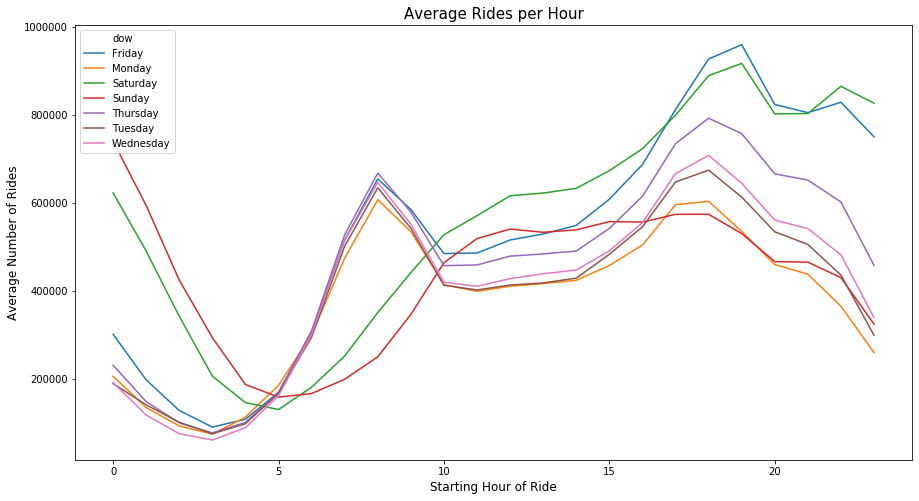

In [543]:
groups = community_df.groupby(['hour','dow']).agg({'rides':'sum'}).reset_index()

plt.figure(figsize=(15,8))
plt.title('Average Rides per Hour', fontsize=15)
sns.lineplot(groups['hour'], groups['rides'], data=groups, hue=groups['dow'], color=['red','red', 'orange','orange', 'red','red','red',])
plt.xlabel('Starting Hour of Ride', fontsize=12)
plt.ylabel('Average Number of Rides', fontsize=12)
plt.legend(loc='upper left')
plt.savefig(fname='hourly.png', transparent=True)
plt.title;

In [25]:
daily_pickup_df = community_df.groupby(['date',
                              'pickup_community_area']).agg({'rides':'sum'}).\
reset_index().sort_values('date', ascending=False)

In [26]:
daily_pickup_df.to_pickle('daily_df.pickle')

In [27]:
community_boundaries.area_numbe = community_boundaries.area_numbe.astype('float64')

In [28]:
community_boundaries.head(1)

,the_geom,perimeter,area,comarea,comarea_id,area_numbe,community,area_num_1,shape_area,shape_len
0,"{'type': 'MultiPolygon', 'coordinates': [[[[-8...",0,0,0,0,35.0,DOUGLAS,35,46004621.1581,31027.0545098


In [29]:
community_boundaries.area_numbe = community_boundaries.area_numbe.astype('float64')

In [439]:
# daily_totals.rides.rolling(7).mean().plot(figsize=(15,8))

In [445]:
daily_totals.sum()/243

rides    294760.440329
dtype: float64

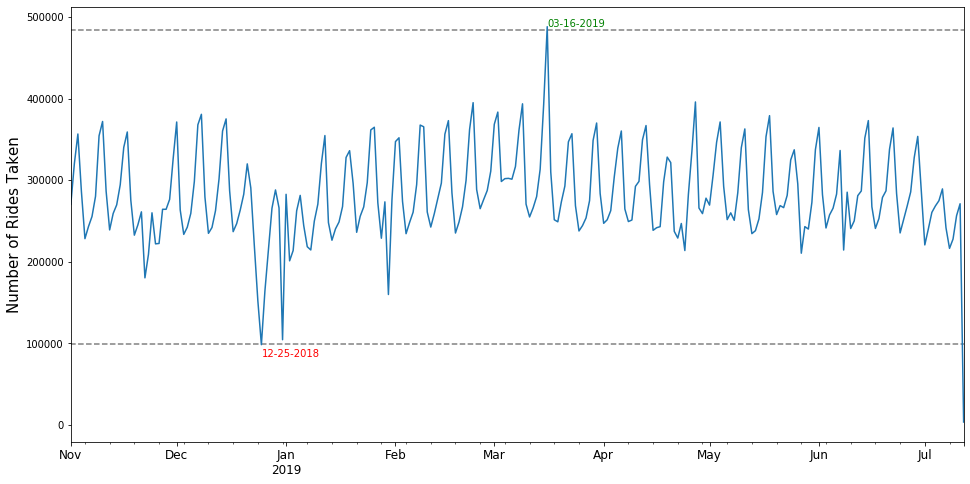

In [443]:
daily_totals = daily_pickup_df.groupby('date').agg({'rides':'sum'})

max_ride = daily_totals[daily_totals.rides == daily_totals.rides.max()]
min_ride = daily_totals[daily_totals.rides == daily_totals[:-1].rides.min()]

daily_totals.plot(figsize=(16,8), label=['total rides'])
plt.title('')

plt.text(max_ride.index[0], max_ride['rides'], max_ride.index[0].strftime('%m-%d-%Y'), color='green')
plt.hlines(max_ride['rides']-4000,0,100000, linestyles='dashed', alpha=.5)

plt.text(min_ride.index[0], min_ride['rides']-15000, min_ride.index[0].strftime('%m-%d-%Y'), color='red')
plt.hlines(min_ride['rides']+1000,0,100000, linestyles='dashed', alpha=.5)

plt.ylabel('Number of Rides Taken', fontsize=15)

plt.xlabel('')
plt.xticks(fontsize=12)
plt.legend([])

plt.savefig('test',transparent=True)
plt.legend().remove();

In [422]:
daily_pickup_df.groupby('community').agg({'rides':'mean'}).sort_values('rides', ascending=False).head(10)

,rides
community,
NEAR NORTH SIDE,49171.633858
LOOP,26768.490119
NEAR WEST SIDE,26090.735178
LAKE VIEW,20145.011811
WEST TOWN,18722.513834
LINCOLN PARK,16317.334646
LOGAN SQUARE,11073.292490
OHARE,10149.857708
UPTOWN,6252.566929


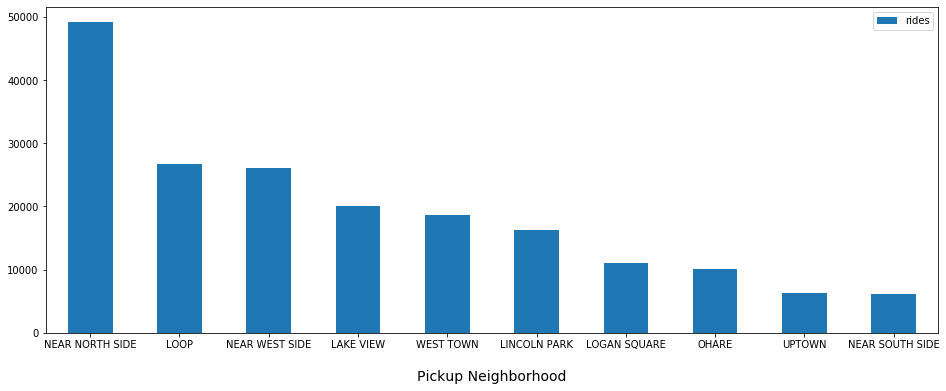

In [536]:
daily_pickup_df.groupby('community').agg({'rides':'mean'}).sort_values('rides', ascending=False).head(10).plot(kind='bar', figsize=(16,6))
plt.xticks(rotation=0)
plt.xlabel('Pickup Neighborhood', fontsize=14, labelpad=20);
plt.savefig('neighborhoods.png', transparent=True)

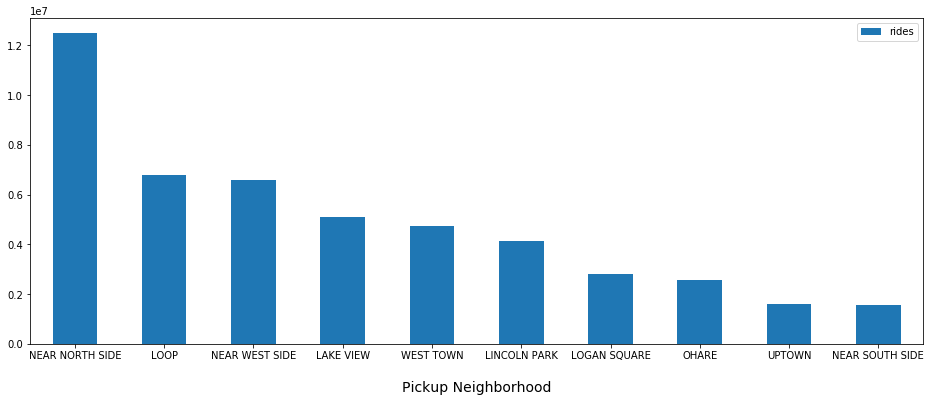

In [375]:
daily_pickup_df.groupby('community').agg({'rides':'sum'}).sort_values('rides', ascending=False).head(10).plot(kind='bar', figsize=(16,6))
plt.xticks(rotation=0)
plt.xlabel('Pickup Neighborhood', fontsize=14, labelpad=20);

In [30]:
to_keep = ['the_geom', 'area_numbe', 'community']

daily_pickup_df = daily_pickup_df.merge(community_boundaries[to_keep],
                                        how='left',
                                        left_on='pickup_community_area',
                                        right_on='area_numbe').drop(columns=['area_numbe'])

In [31]:
daily_pickup_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19502 entries, 0 to 19501
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   date                   19502 non-null  datetime64[ns]
 1   pickup_community_area  19502 non-null  float64       
 2   rides                  19502 non-null  float64       
 3   the_geom               19502 non-null  object        
 4   community              19502 non-null  object        
dtypes: datetime64[ns](1), float64(2), object(2)
memory usage: 914.2+ KB


In [32]:
community_df.pickup_community_area = community_df.pickup_community_area.astype('float64')

In [33]:
def shrink_df(df):
    df.date = pd.to_datetime(df.date)
    df.hour = df.hour.astype('int16')
    df.pickup_community_area = df.pickup_community_area.astype('float16')
    df.dropoff_community_area = df.dropoff_community_area.astype('float16')
    df.total_fare = df.total_fare.astype('float32')
    df.avg_fare = df.avg_fare.astype('float32')
    df.total_miles = df.total_miles.astype('float32')
    df.avg_trip_mile = df.avg_trip_mile.astype('float32')
    df.rides = df.rides.astype('int16')
    
    return daily_pickup_df

In [34]:
# daily_pickup_df = shrink_df(daily_pickup_df)

In [35]:
# community_df['date'] = community_df.apply(lambda row: row['date'] + pd.to_timedelta(row['hour'], unit='h'), axis=1)

In [36]:
# resample

In [46]:
daily_df = community_df.groupby('date').agg({'total_fare': 'sum',
                                             'avg_fare': 'mean',
                                             'total_miles': 'sum',
                                             'avg_trip_mile': 'mean',
                                             'rides': 'sum'})

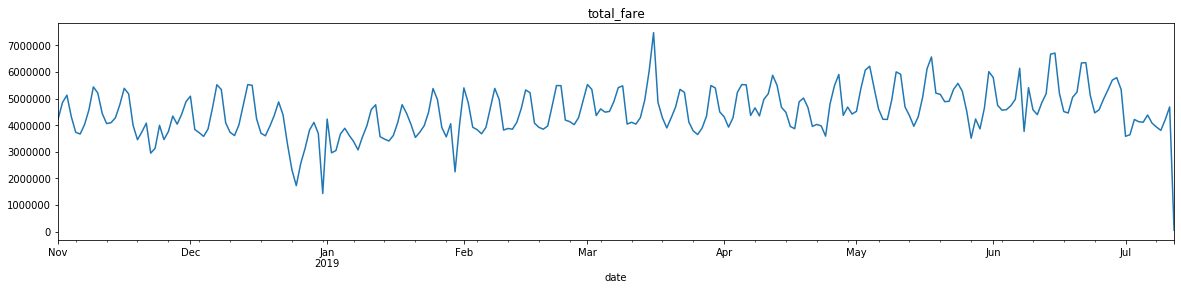

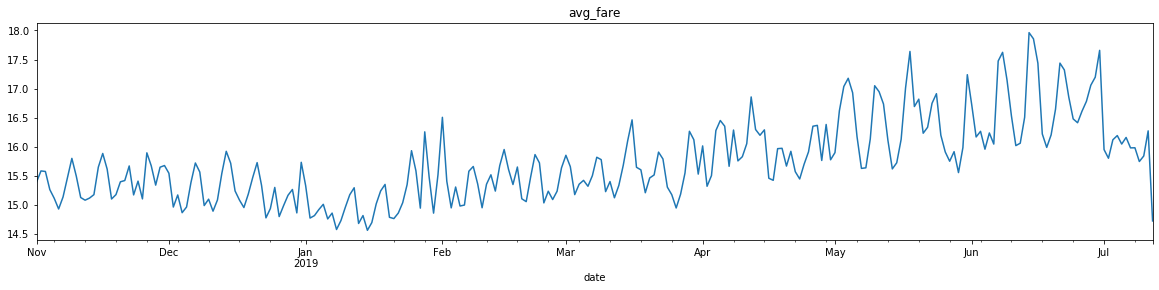

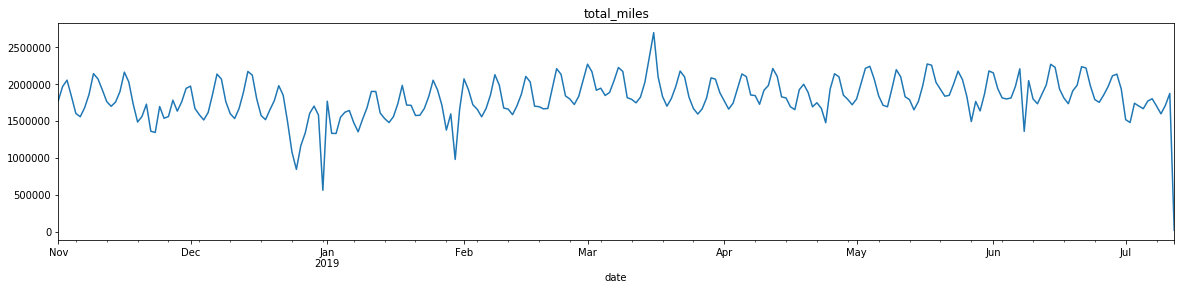

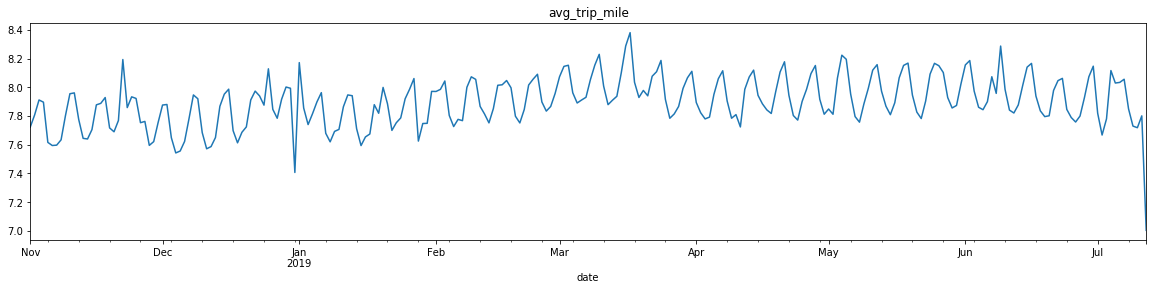

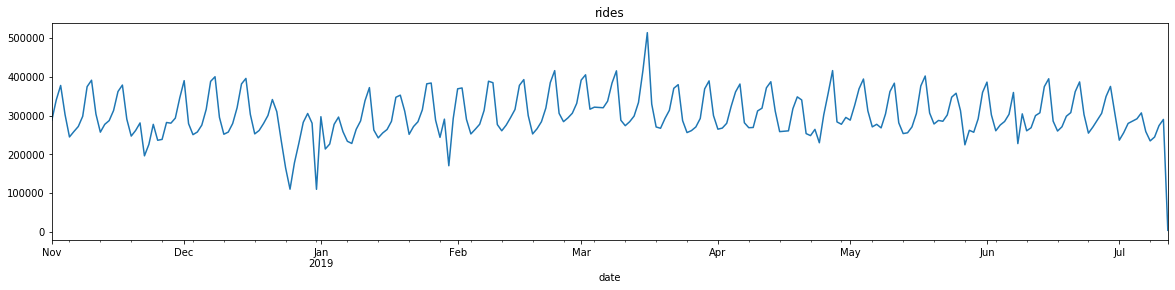

In [47]:
for col in daily_df:
    daily_df[col].plot(figsize=(20,4))
    plt.title(col)
    plt.show()

# Weather

In [48]:
def get_weather(start, end, *args):
    
    '''
    input: start and end dates (as YYYY-MM-DD strings)
    output: pandas dataframe of hourly weather for the input dates
    
    * if you have a weather_df pickled in the directory this is running,
        it will load that file instead of calling the API
        
    '''
    # check to see if weather pickle exists
    if os.path.exists('weather_df.pickle'):
        print('loading pickle!')
        weather_df = pd.read_pickle('weather_df.pickle')
        
    else:
        print('calling Dark Sky API')
    
        date_range = [x.isoformat() for x in pd.date_range(start, end)]

        weather_df = pd.DataFrame()

        key = '8d25a286fd2d683742682edcd656596e'
        lat = '41.8781'
        long = '-87.6298'
        exclude = 'currently, flags'

        for date in date_range:

            url = f'https://api.darksky.net/forecast/{key}/{lat},{long},{date}?exclude={exclude}'

            response = requests.get(url).json()
            response = pd.DataFrame(response['hourly']['data'])
            results = results.append(response, ignore_index=True)

        weather_df['time'] = pd.to_datetime(weather_df['time'], unit='s')
    
    return weather_df

In [49]:
%time weather_df = get_weather('2018-10-31', '2020-01-01')

loading pickle!
CPU times: user 9.5 ms, sys: 13.2 ms, total: 22.7 ms
Wall time: 24 ms


In [50]:
weather_df.to_pickle('weather_df.pickle')

In [2]:
import pandas as pd

In [3]:
weather_df = pd.read_pickle('weather_df.pickle')

In [4]:
weather_df

,time,summary,icon,precipIntensity,precipProbability,precipType,temperature,apparentTemperature,dewPoint,humidity,pressure,windSpeed,windGust,windBearing,cloudCover,uvIndex,visibility,ozone,precipAccumulation
0,2018-10-31 05:00:00,Light Rain,rain,0.0912,0.74,rain,54.00,54.00,53.00,0.96,1008.0,5.16,7.01,348,1.00,0,5.128,272.7,NaN
1,2018-10-31 06:00:00,Rain,rain,0.1095,0.69,rain,52.59,52.59,51.89,0.97,1007.8,5.84,8.42,359,1.00,0,5.620,274.1,NaN
2,2018-10-31 07:00:00,Light Rain,rain,0.0823,0.72,rain,50.56,50.56,50.56,1.00,1008.1,6.78,10.94,355,1.00,0,5.815,274.2,NaN
3,2018-10-31 08:00:00,Light Rain,rain,0.0800,0.77,rain,51.07,51.07,50.46,0.98,1008.8,8.04,12.46,344,0.99,0,5.520,274.2,NaN
4,2018-10-31 09:00:00,Light Rain,rain,0.0661,0.72,rain,50.85,50.85,49.60,0.95,1009.7,7.53,13.25,342,1.00,0,8.966,274.8,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10268,2020-01-02 01:00:00,Clear,clear-night,0.0003,0.01,rain,38.73,31.06,29.06,0.68,1002.9,12.49,26.17,190,0.15,0,10.000,329.2,NaN
10269,2020-01-02 02:00:00,Clear,clear-night,0.0002,0.02,rain,39.14,29.91,29.43,0.68,1003.2,17.85,27.10,193,0.17,0,10.000,328.2,NaN
10270,2020-01-02 03:00:00,Clear,clear-night,0.0000,0.00,NaN,39.02,31.53,29.17,0.68,1003.1,12.21,27.65,196,0.18,0,10.000,328.4,NaN
10271,2020-01-02 04:00:00,Clear,clear-night,0.0005,0.01,rain,38.92,29.56,30.14,0.70,1002.7,18.03,27.90,195,0.19,0,10.000,330.9,NaN


In [607]:
number_cols = [x for x in weather_df.columns if weather_df[x].dtype != object]

In [617]:
weather_df.dtypes 

time                   datetime64[ns]
summary                        object
icon                           object
precipIntensity               float64
precipProbability             float64
precipType                     object
temperature                   float64
apparentTemperature           float64
dewPoint                      float64
humidity                      float64
pressure                      float64
windSpeed                     float64
windGust                      float64
windBearing                     int64
cloudCover                    float64
uvIndex                         int64
visibility                    float64
ozone                         float64
precipAccumulation            float64
dtype: object

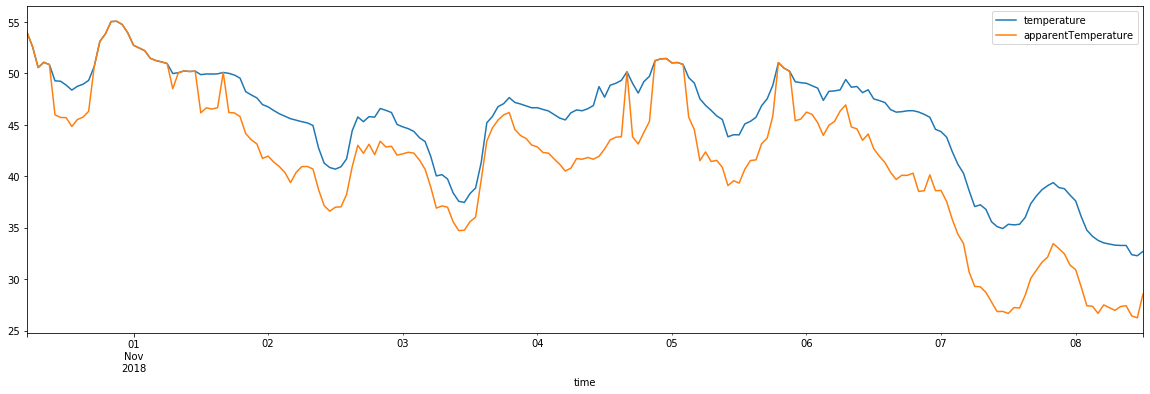

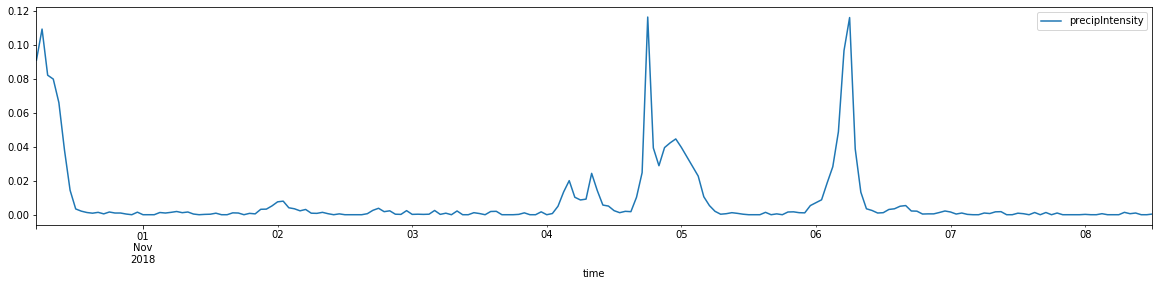

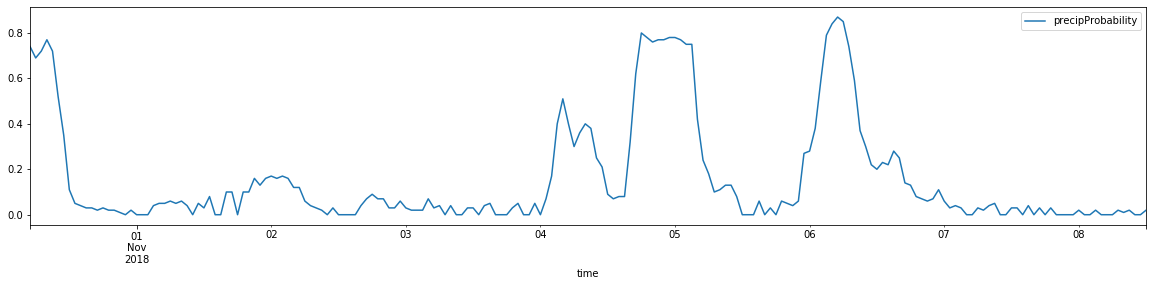

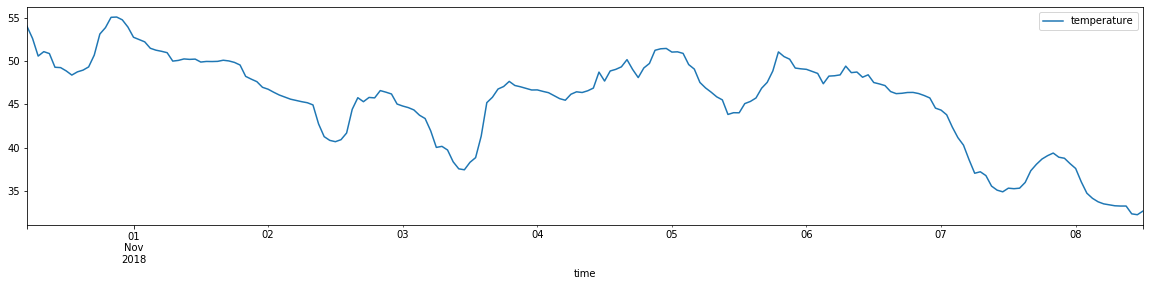

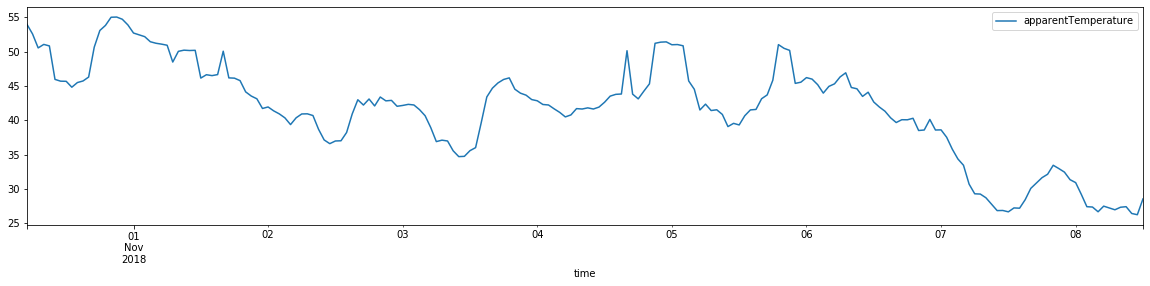

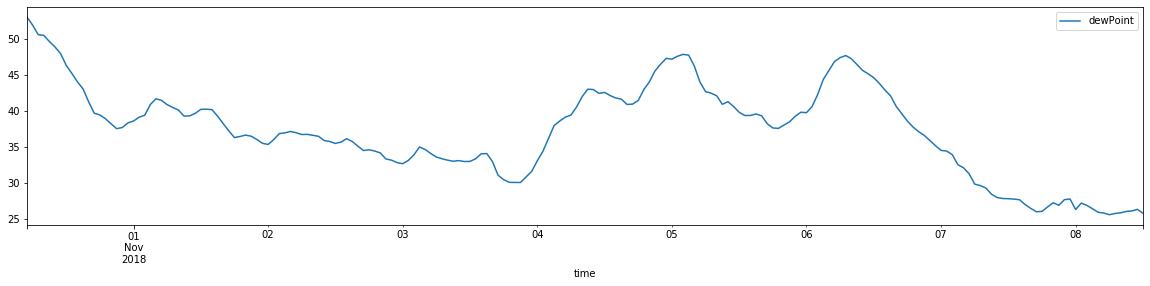

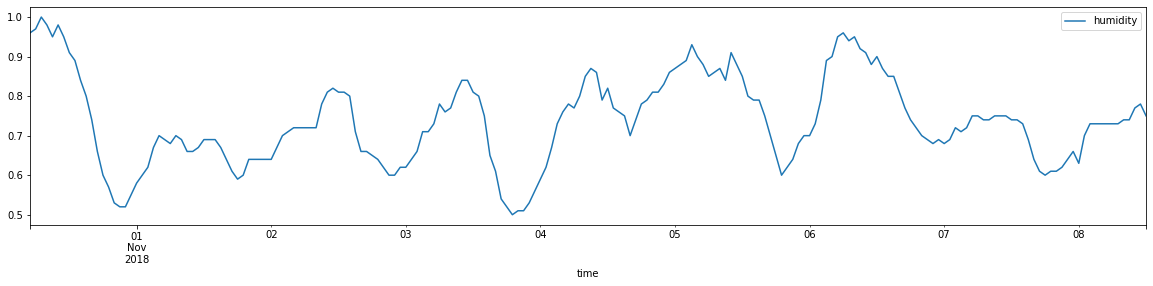

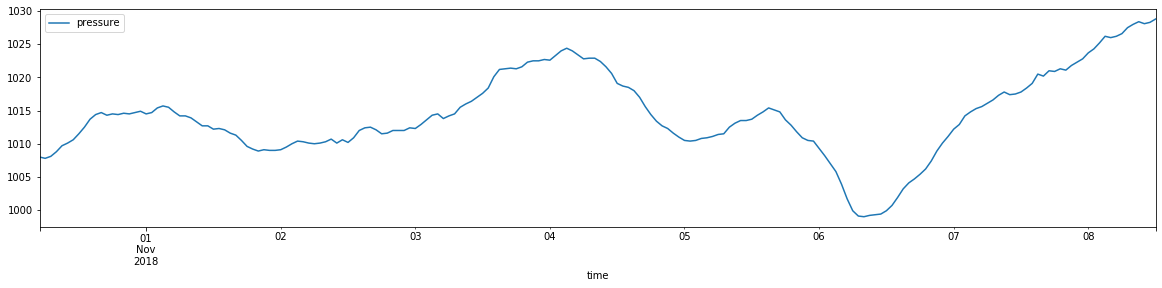

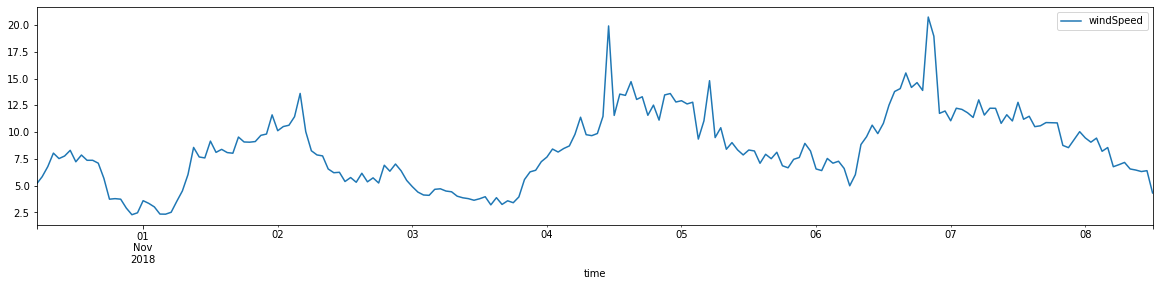

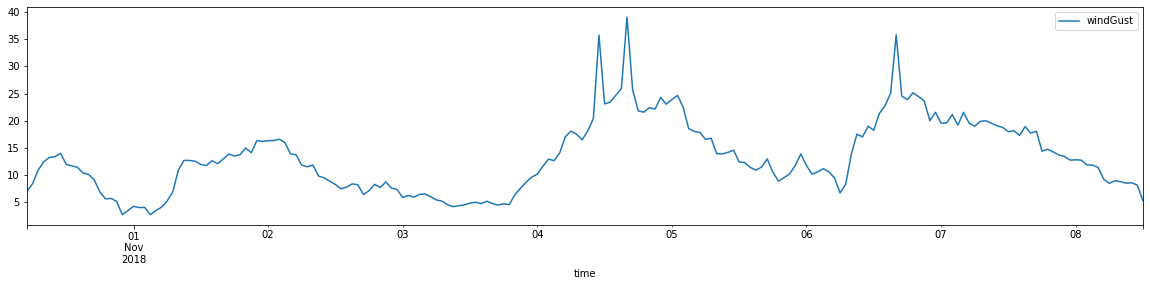

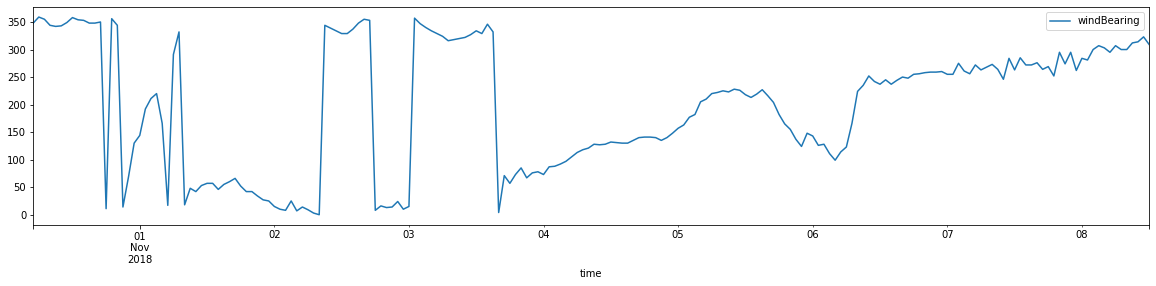

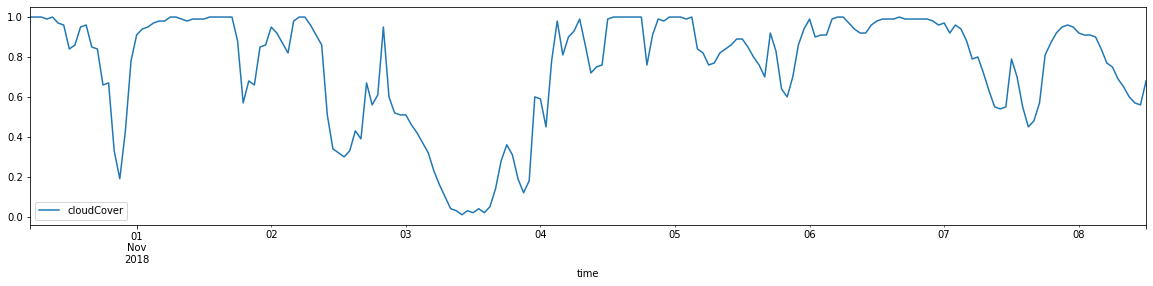

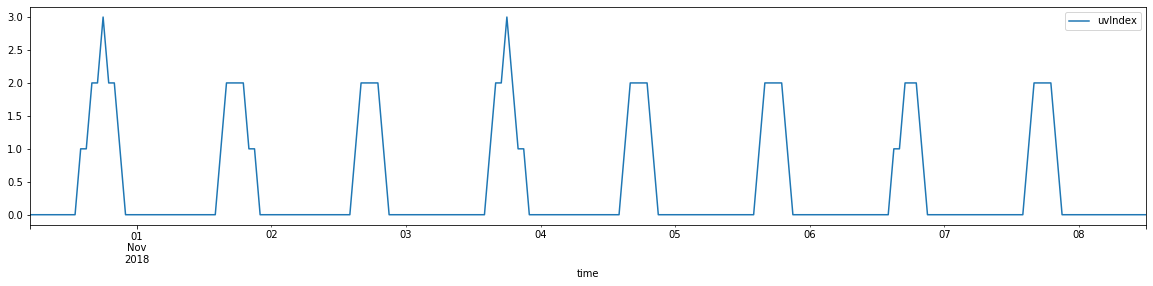

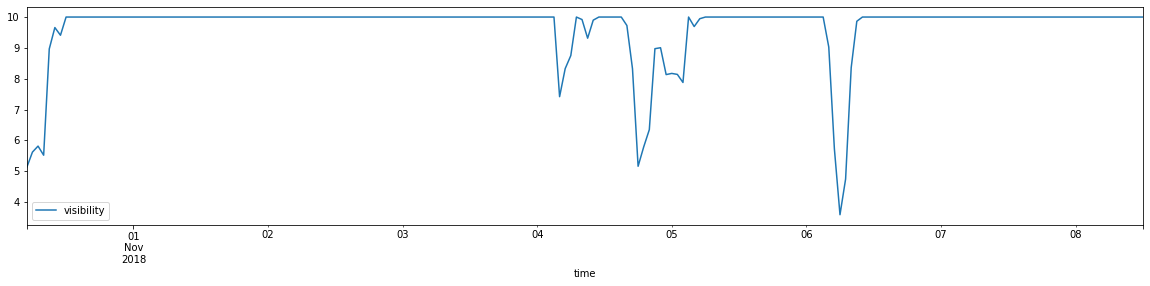

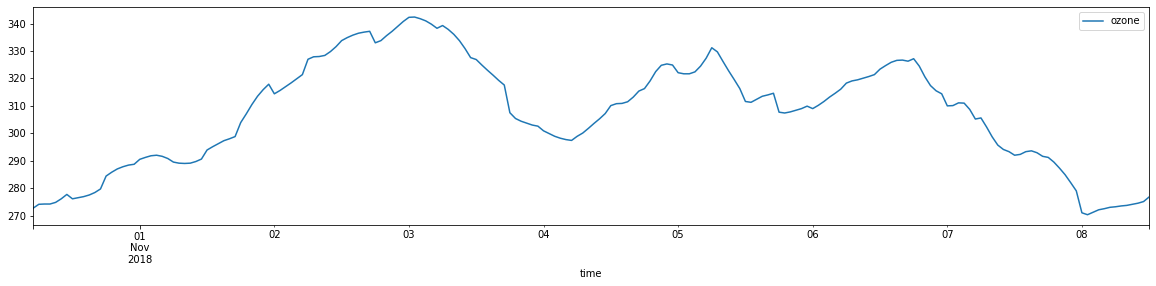

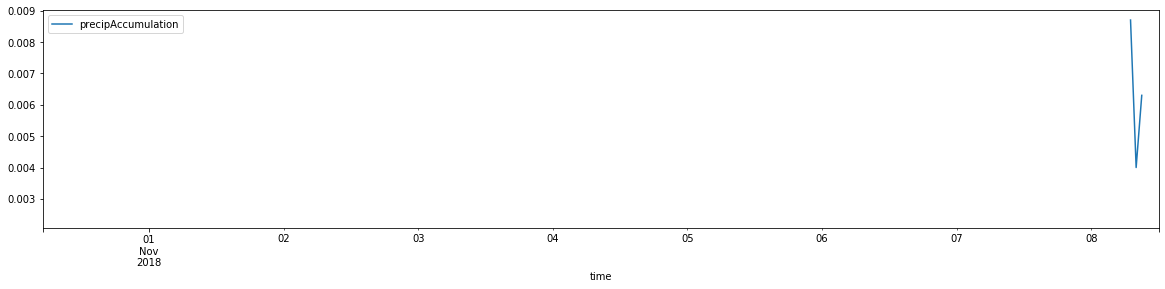

In [627]:
weather_df.groupby('time').agg({'temperature':'mean',
                               'apparentTemperature': 'mean'})[:200].plot(figsize=(20,6))

for col in weather_df.columns:
    col_type = weather_df[col].dtype
    if col_type == int or col_type == float:
        weather_df[:200].groupby('time').agg({col:'mean'}).plot(figsize=(20,4))

# Merging

In [659]:
merged_daily = community_df.groupby('date_time').agg({'total_fare':'sum',
                                                      'avg_fare':'sum',
                                                      'total_miles':'sum',
                                                      'avg_trip_mile':'sum',
                                                      'rides':'sum'}).reset_index().set_index('date_time')

merged_daily = merged_daily.merge(weather_df.set_index('time').fillna(0),
                                  left_index=True,
                                  right_index=True)

In [661]:
merged_daily.summary.unique(), merged_daily.icon.unique()

(array(['Overcast', 'Partly Cloudy', 'Mostly Cloudy', 'Clear',
        'Possible Drizzle', 'Possible Light Rain',
        'Possible Drizzle and Windy', 'Rain', 'Light Rain',
        'Possible Light Snow', 'Possible Flurries', 'Drizzle',
        'Snow and Windy', 'Snow', 'Light Snow', 'Foggy',
        'Windy and Overcast', 'Windy and Mostly Cloudy',
        'Windy and Partly Cloudy', 'Windy', 'Humid',
        'Humid and Mostly Cloudy', 'Humid and Partly Cloudy'], dtype=object),
 array(['cloudy', 'partly-cloudy-day', 'partly-cloudy-night', 'clear-day',
        'clear-night', 'rain', 'snow', 'fog', 'wind'], dtype=object))

In [663]:
merged_daily.to_pickle('merged_daily.pickle')

# Scooters

In [2]:
# Example authenticated client (needed for non-public datasets):
client = Socrata('data.cityofchicago.org',
                 'OfytEmI12Fl0Yq13HTVq7ROlF')

# First 2000 results, returned as JSON from API / converted to Python list of
# dictionaries by sodapy.
results = client.get("2kfw-zvte",
                     limit=712_000)

# Convert to pandas DataFrame
results_df = pd.DataFrame(results)

In [32]:
# results_df.to_pickle('/Users/dcorley/Desktop/scooter_rides.pickle')

In [3]:
results_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 710839 entries, 0 to 710838
Data columns (total 20 columns):
trip_id                        710839 non-null object
start_time                     710839 non-null object
end_time                       710839 non-null object
trip_distance                  710839 non-null object
trip_duration                  710839 non-null object
accuracy                       710839 non-null object
start_community_area_number    613450 non-null object
end_community_area_number      612923 non-null object
start_community_area_name      613450 non-null object
end_community_area_name        612923 non-null object
start_centroid_latitude        613451 non-null object
start_centroid_longitude       613451 non-null object
start_centroid_location        613451 non-null object
end_centroid_latitude          612923 non-null object
end_centroid_longitude         612923 non-null object
end_centroid_location          612923 non-null object
:@computed_region_bdys_3d

In [4]:
def get_coords(x):
    if type(x) == dict:
        coords = x['coordinates']
    else:
        coords = None
        
    return coords

In [5]:
results_df['start_centroid_location'] = results_df['start_centroid_location'].map(lambda x: get_coords(x))
results_df['end_centroid_location'] = results_df['end_centroid_location'].map(lambda x: get_coords(x))

In [7]:
results_df.sample(1)

,trip_id,start_time,end_time,trip_distance,trip_duration,accuracy,start_community_area_number,end_community_area_number,start_community_area_name,end_community_area_name,start_centroid_latitude,start_centroid_longitude,start_centroid_location,end_centroid_latitude,end_centroid_longitude,end_centroid_location,:@computed_region_bdys_3d7i,:@computed_region_vrxf_vc4k,start_census_tract,end_census_tract
214732,7e7dbdf9-a9f1-4d7b-ba6d-689cb4b59d2b,2019-07-11T16:00:00.000,2019-07-11T16:00:00.000,3468,520,152,24,24,WEST TOWN,WEST TOWN,41.9012067343156,-87.6763571260391,"[-87.6763571260391, 41.9012067343156]",41.9012067343156,-87.6763571260391,"[-87.6763571260391, 41.9012067343156]",462,25,NaN,NaN


In [27]:
[x for x in results_df.end_community_area_name.unique() if x not in results_df.start_community_area_name.unique()]

[nan,
 'LAKE VIEW',
 'GARFIELD RIDGE',
 'JEFFERSON PARK',
 'ALBANY PARK',
 'MCKINLEY PARK',
 'ARCHER HEIGHTS',
 'LINCOLN SQUARE',
 'KENWOOD',
 'WEST RIDGE',
 'CHICAGO LAWN',
 'WEST ENGLEWOOD',
 'NORWOOD PARK']

In [236]:
community_areas = results_df.groupby(['start_community_area_name',
                    'end_community_area_name']).agg({'start_centroid_latitude':'max',
                                                     'start_centroid_longitude': 'max',
                                                     'end_centroid_latitude':'max',
                                                     'end_centroid_longitude': 'max',
                                                    'trip_id':'count'}).reset_index()

In [237]:
community_areas

,start_community_area_name,end_community_area_name,start_centroid_latitude,start_centroid_longitude,end_centroid_latitude,end_centroid_longitude,trip_id
0,ARMOUR SQUARE,ARMOUR SQUARE,41.8420774867429,-87.6339736975322,41.8420774867429,-87.6339736975322,1
1,AUSTIN,ALBANY PARK,41.8941012961134,-87.7631118242259,41.9680684656836,-87.7215597838681,1
2,AUSTIN,AUSTIN,41.9146186588449,-87.7967955436002,41.9146186588449,-87.7967955436002,14535
3,AUSTIN,AVONDALE,41.9129077726091,-87.7753955652535,41.9428681074369,-87.7302981167554,42
4,AUSTIN,BELMONT CRAGIN,41.9146186588449,-87.7967955436002,41.9352176386575,-87.7880224758376,1236
...,...,...,...,...,...,...,...
406,WEST TOWN,UPTOWN,41.9012067343156,-87.6763571260391,41.9658120777132,-87.6558793191515,2
407,WEST TOWN,WEST GARFIELD PARK,41.9012067343156,-87.6763571260391,41.8785946681995,-87.7302325118985,38
408,WEST TOWN,WEST TOWN,41.9147877430097,-87.7018836562075,41.9147877430097,-87.7018836562075,138175
409,WOODLAWN,NEAR WEST SIDE,41.7788764106426,-87.5949253613625,41.8740053848845,-87.6635178867003,2


In [54]:
results_df['start_census_tract'].unique()[:10]

array([nan, '17031833100', '17031241500', '17031241400', '17031242100',
       '17031833000', '17031241600', '17031240200', '17031831000',
       '17031242200'], dtype=object)

In [59]:
results_df['start_community_area_name'].unique()

array(['LOWER WEST SIDE', 'WEST TOWN', 'WEST GARFIELD PARK',
       'NEAR WEST SIDE', 'LOGAN SQUARE', 'AUSTIN', nan, 'NORTH LAWNDALE',
       'AVONDALE', 'PORTAGE PARK', 'MONTCLARE', 'IRVING PARK', 'DUNNING',
       'HUMBOLDT PARK', 'BELMONT CRAGIN', 'EAST GARFIELD PARK', 'HERMOSA',
       'NEAR NORTH SIDE', 'SOUTH LAWNDALE', 'NORTH CENTER', 'BRIDGEPORT',
       'LINCOLN PARK', 'LOOP', 'OHARE', 'BRIGHTON PARK', 'NEW CITY',
       'UPTOWN', 'WOODLAWN', 'NEAR SOUTH SIDE', 'ARMOUR SQUARE',
       'GAGE PARK'], dtype=object)

In [57]:
results_df[':@computed_region_bdys_3d7i'].unique()

array(['126', '462', '675', '91', '88', '322', '482', '481', '518', '63',
       '673', nan, '483', '33', '216', '437', '179', '543', '579', '260',
       '136', '72', '326', '444', '438', '298', '484', '476', '373', '97',
       '343', '456', '80', '365', '371', '294', '387', '548', '737',
       '108', '522', '302', '516', '485', '784', '786', '550', '178',
       '70', '463', '209', '301', '180', '549', '186', '541', '517',
       '521', '519', '520', '240', '139', '215', '87', '542', '321',
       '310', '546', '312', '544', '295', '396', '176', '547', '324', '5',
       '251', '613', '287', '465', '323', '366', '107', '55', '329',
       '304', '468', '58', '425', '138', '467', '90', '676', '37', '600',
       '545', '288', '76', '350', '74', '305', '355', '659', '598', '34',
       '150', '439', '674', '759', '177', '227', '390', '360', '597',
       '411', '460', '386', '758', '464', '135', '285', '388', '466',
       '596', '562', '744', '202', '249', '250', '327', '57', '389',

In [56]:
results_df[':@computed_region_vrxf_vc4k'].unique()

array(['33', '25', '27', '29', '23', '26', nan, '30', '22', '15', '18',
       '16', '17', '24', '19', '28', '37', '21', '32', '46', '58', '68',
       '38', '75', '55', '59', '31', '9', '34', '35', '61'], dtype=object)

In [71]:
results_df[['start_community_area_name', ':@computed_region_bdys_3d7i', ':@computed_region_vrxf_vc4k','start_census_tract']].nunique()

start_community_area_name       30
:@computed_region_bdys_3d7i    258
:@computed_region_vrxf_vc4k     30
start_census_tract             245
dtype: int64

In [75]:
results_df.groupby(['start_community_area_name', ':@computed_region_vrxf_vc4k']).agg({'trip_id': 'count'})

trip_id
start_community_area_name :@computed_region_vrxf_vc4k         
ARMOUR SQUARE             35                                 1
AUSTIN                    19                                 1
                          26                             19276
AVONDALE                  22                             17461
                          23                                42
BELMONT CRAGIN            15                                 1
                          19                             20552
                          26                                10
BRIDGEPORT                58                                38
BRIGHTON PARK             55                                 1
DUNNING                   17                              1766
EAST GARFIELD PARK        28                              7467
GAGE PARK                 61                                 1
HERMOSA                   19                                 1
                          21                             11466
                          23                                 2
HUMBOLDT PARK             24                             11904
                          25                                 2
IRVING PARK               16                              7992
LINCOLN PARK              23                                 1
                          68                               122
LOGAN SQUARE              23                             90711
                          24                                 5
                          25                                12
LOOP                      38                                 4
LOWER WEST SIDE           29                                12
                          33                             11709
MONTCLARE                 18                              2066
                          26                                 1
NEAR NORTH SIDE           37                               141
NEAR SOUTH SIDE           34                                 1
NEAR WEST SIDE            25                                 2
                          29                            193871
                          33                                 1
                          37                                 4
NEW CITY                  59                                 3
NORTH CENTER              46                                30
NORTH LAWNDALE            28                                 1
                          30                             10250
OHARE                     75                                 1
PORTAGE PARK              15                              7082
SOUTH LAWNDALE            32                              8080
UPTOWN                    31                                 1
WEST GARFIELD PARK        27                              5073
WEST TOWN                 23                              4845
                          25                            174334
                          29                                31
                          37                              7067
WOODLAWN                  9                                  5

In [72]:
results_df.sort_values('start_community_area_number').head(30)

,trip_id,start_time,end_time,trip_distance,trip_duration,accuracy,start_community_area_number,end_community_area_number,start_community_area_name,end_community_area_name,start_centroid_latitude,start_centroid_longitude,start_centroid_location,end_centroid_latitude,end_centroid_longitude,end_centroid_location,:@computed_region_bdys_3d7i,:@computed_region_vrxf_vc4k,start_census_tract,end_census_tract
95020,11d69fc6-84a1-ae2e-11d6-9fc684a1ae2e,2019-06-26T16:00:00.000,2019-06-26T16:00:00.000,498,161,10,15,19,PORTAGE PARK,BELMONT CRAGIN,41.9540281621501,-87.7633999111184,"[-87.7633999111184, 41.9540281621501]",41.9272607415187,-87.7655018368979,"[-87.7655018368979, 41.9272607415187]",260,15,NaN,NaN
101787,11d7e222-cd4d-3b1e-11d7-e222cd4d3b1e,2019-06-27T15:00:00.000,2019-06-27T15:00:00.000,1416,503,10,15,20,PORTAGE PARK,HERMOSA,41.9540281621501,-87.7633999111184,"[-87.7633999111184, 41.9540281621501]",41.9243477570064,-87.7347401601846,"[-87.7347401601846, 41.9243477570064]",260,15,NaN,NaN
456905,1061567f-19fb-4139-b411-469af549626f,2019-08-17T08:00:00.000,2019-08-17T08:00:00.000,1532,340,10,15,19,PORTAGE PARK,BELMONT CRAGIN,41.9540281621501,-87.7633999111184,"[-87.7633999111184, 41.9540281621501]",41.9272607415187,-87.7655018368979,"[-87.7655018368979, 41.9272607415187]",260,15,NaN,NaN
101786,11d7e223-aa28-927a-11d7-e223aa28927a,2019-06-27T15:00:00.000,2019-06-27T15:00:00.000,1384,489,10,15,20,PORTAGE PARK,HERMOSA,41.9540281621501,-87.7633999111184,"[-87.7633999111184, 41.9540281621501]",41.9243477570064,-87.7347401601846,"[-87.7347401601846, 41.9243477570064]",260,15,NaN,NaN
101785,7898a774-f452-44ea-b888-8a17d899d846,2019-06-27T15:00:00.000,2019-06-27T16:00:00.000,10135,2809,10,15,23,PORTAGE PARK,HUMBOLDT PARK,41.9526508525478,-87.7452551548857,"[-87.7452551548857, 41.9526508525478]",41.9117235264421,-87.7339492805549,"[-87.7339492805549, 41.9117235264421]",139,15,17031831700,17031230500
26454,564e68db-93ab-4f78-bde5-e2ef073ccaab,2019-06-18T16:00:00.000,2019-06-18T17:00:00.000,11911,5419,10,15,17,PORTAGE PARK,DUNNING,41.9540281621501,-87.7633999111184,"[-87.7633999111184, 41.9540281621501]",41.9465106631739,-87.8060198448135,"[-87.8060198448135, 41.9465106631739]",260,15,NaN,NaN
456911,3b759a31-8b66-4c6e-bebb-07be6a13106d,2019-08-17T08:00:00.000,2019-08-17T08:00:00.000,2461,468,10,15,21,PORTAGE PARK,AVONDALE,41.9540281621501,-87.7633999111184,"[-87.7633999111184, 41.9540281621501]",41.938665887698,-87.7112106378686,"[-87.7112106378686, 41.938665887698]",260,15,NaN,NaN
254727,027aff35-53f2-483a-8b75-6484955e8305,2019-07-16T17:00:00.000,2019-07-16T17:00:00.000,4739,1167,10,15,18,PORTAGE PARK,MONTCLARE,41.9540281621501,-87.7633999111184,"[-87.7633999111184, 41.9540281621501]",41.9292976909612,-87.7980323248709,"[-87.7980323248709, 41.9292976909612]",260,15,NaN,NaN
101766,45a77512-97ae-4fe7-b361-7e03d9d9eb9b,2019-06-27T15:00:00.000,2019-06-27T15:00:00.000,1398,451,10,15,16,PORTAGE PARK,IRVING PARK,41.9526508525478,-87.7452551548857,"[-87.7452551548857, 41.9526508525478]",41.9499767000057,-87.7306829266633,"[-87.7306829266633, 41.949976700005706]",139,15,17031831700,17031161000
629064,e19ea43d-998c-10d9-2259-56a8188b7406,2019-09-14T21:00:00.000,2019-09-14T22:00:00.000,2827,676,10,15,19,PORTAGE PARK,BELMONT CRAGIN,41.9540281621501,-87.7633999111184,"[-87.7633999111184, 41.9540281621501]",41.9272607415187,-87.7655018368979,"[-87.7655018368979, 41.9272607415187]",260,15,NaN,NaN


In [207]:
results_df.groupby('start_time').count()

,trip_id,end_time,trip_distance,trip_duration,accuracy,start_community_area_number,end_community_area_number,start_community_area_name,end_community_area_name,start_centroid_latitude,start_centroid_longitude,start_centroid_location,end_centroid_latitude,end_centroid_longitude,end_centroid_location,:@computed_region_bdys_3d7i,:@computed_region_vrxf_vc4k,start_census_tract,end_census_tract
start_time,,,,,,,,,,,,,,,,,,,
2019-06-15T04:00:00.000,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0
2019-06-15T06:00:00.000,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,3,3
2019-06-15T07:00:00.000,38,38,38,38,38,36,36,36,36,36,36,36,36,36,36,36,36,21,21
2019-06-15T08:00:00.000,59,59,59,59,59,54,54,54,54,54,54,54,54,54,54,54,54,23,23
2019-06-15T09:00:00.000,193,193,193,193,193,178,178,178,178,178,178,178,178,178,178,178,178,103,103
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-10-15T20:00:00.000,167,167,167,167,167,138,138,138,138,138,138,138,138,138,138,138,138,43,43
2019-10-15T21:00:00.000,103,103,103,103,103,84,84,84,84,84,84,84,84,84,84,84,84,20,20
2019-10-15T22:00:00.000,54,54,54,54,54,48,48,48,48,48,48,48,48,48,48,48,48,7,7


In [169]:
results_df.groupby('start_community_area_name').count()

,trip_id,start_time,end_time,trip_distance,trip_duration,accuracy,start_community_area_number,end_community_area_number,end_community_area_name,start_centroid_latitude,start_centroid_longitude,start_centroid_location,end_centroid_latitude,end_centroid_longitude,end_centroid_location,:@computed_region_bdys_3d7i,:@computed_region_vrxf_vc4k,start_census_tract,end_census_tract
start_community_area_name,,,,,,,,,,,,,,,,,,,
ARMOUR SQUARE,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0
AUSTIN,19277,19277,19277,19277,19277,19277,19277,18852,18852,19277,19277,19277,18852,18852,18852,19277,19277,2770,2664
AVONDALE,17503,17503,17503,17503,17503,17503,17503,17499,17499,17503,17503,17503,17499,17499,17499,17503,17503,5502,5500
BELMONT CRAGIN,20563,20563,20563,20563,20563,20563,20563,20499,20499,20563,20563,20563,20499,20499,20499,20563,20563,4612,4590
BRIDGEPORT,38,38,38,38,38,38,38,38,38,38,38,38,38,38,38,38,38,7,7
BRIGHTON PARK,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0
DUNNING,1766,1766,1766,1766,1766,1766,1766,1745,1745,1766,1766,1766,1745,1745,1745,1766,1766,318,311
EAST GARFIELD PARK,7467,7467,7467,7467,7467,7467,7467,7457,7457,7467,7467,7467,7457,7457,7457,7467,7467,2159,2155
GAGE PARK,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0


In [37]:
results_df.groupby(['start_community_area_name', ':@computed_region_bdys_3d7i']).count()

trip_id  start_time  \
start_community_area_name :@computed_region_bdys_3d7i                        
ARMOUR SQUARE             346                                1           1   
AUSTIN                    184                               19          19   
                          307                                1           1   
                          523                               80          80   
                          562                               56          56   
...                                                        ...         ...   
WEST TOWN                 546                              460         460   
                          547                             1869        1869   
                          63                                21          21   
                          784                               10          10   
WOODLAWN                  27                                 5           5   

                                                       end_time  \
start_community_area_name :@computed_region_bdys_3d7i             
ARMOUR SQUARE             346                                 1   
AUSTIN                    184                                19   
                          307                                 1   
                          523                                80   
                          562                                56   
...                                                         ...   
WEST TOWN                 546                               460   
                          547                              1869   
                          63                                 21   
                          784                                10   
WOODLAWN                  27                                  5   

                                                       trip_distance  \
start_community_area_name :@computed_region_bdys_3d7i                  
ARMOUR SQUARE             346                                      1   
AUSTIN                    184                                     19   
                          307                                      1   
                          523                                     80   
                          562                                     56   
...                                                              ...   
WEST TOWN                 546                                    460   
                          547                                   1869   
                          63                                      21   
                          784                                     10   
WOODLAWN                  27                                       5   

                                                       trip_duration  \
start_community_area_name :@computed_region_bdys_3d7i                  
ARMOUR SQUARE             346                                      1   
AUSTIN                    184                                     19   
                          307                                      1   
                          523                                     80   
                          562                                     56   
...                                                              ...   
WEST TOWN                 546                                    460   
                          547                                   1869   
                          63                                      21   
                          784                                     10   
WOODLAWN                  27                                       5   

                                                       accuracy  \
start_community_area_name :@computed_region_bdys_3d7i             
ARMOUR SQUARE             346                                 1   
AUSTIN                    184                                19   
                          

In [15]:
result_groupby = results_df.groupby(['start_community_area_name', 'end_community_area_name']).agg({'trip_id':'count'}).reset_index()

In [48]:
census_tract_results = client.get('74p9-q2aq')

In [49]:
census_tract = pd.DataFrame(census_tract_results)

In [63]:
census_tract['the_geom'] = census_tract.the_geom.map(lambda x: x['coordinates'][0][0])

In [66]:
census_tract

,the_geom,statefp10,countyfp10,tractce10,geoid10,name10,namelsad10,commarea,commarea_n,notes
0,"[[-87.62404799998049, 41.73021699998396], [-87...",17,031,842400,17031842400,8424,Census Tract 8424,44,44,
1,"[[-87.6860799999848, 41.82295600001154], [-87....",17,031,840300,17031840300,8403,Census Tract 8403,59,59,
2,"[[-87.62934700001182, 41.8527970000265], [-87....",17,031,841100,17031841100,8411,Census Tract 8411,34,34,
3,"[[-87.68813499997718, 41.85569099999095], [-87...",17,031,841200,17031841200,8412,Census Tract 8412,31,31,
4,"[[-87.63312200003458, 41.87448800002695], [-87...",17,031,839000,17031839000,8390,Census Tract 8390,32,32,
...,...,...,...,...,...,...,...,...,...,...
796,"[[-87.65745700003984, 41.93257799999479], [-87...",17,031,070400,17031070400,704,Census Tract 704,7,7,
797,"[[-87.66349399996524, 41.93036099997365], [-87...",17,031,070500,17031070500,705,Census Tract 705,7,7,
798,"[[-87.71436299999318, 41.9829969999959], [-87....",17,031,130300,17031130300,1303,Census Tract 1303,13,13,
799,"[[-87.71317299997403, 41.855230999977856], [-8...",17,031,292200,17031292200,2922,Census Tract 2922,29,29,


# Community Areas

In [69]:
community_area_results = client.get('igwz-8jzy')

In [71]:
community_area = pd.DataFrame(community_area_results)

In [73]:
community_area['the_geom'] = community_area.the_geom.map(lambda x: x['coordinates'][0][0])

In [78]:
community_area

,the_geom,perimeter,area,comarea,comarea_id,area_numbe,community,area_num_1,shape_area,shape_len
0,"[[-87.60914087617894, 41.84469250265398], [-87...",0,0,0,0,35,DOUGLAS,35,46004621.1581,31027.0545098
1,"[[-87.59215283879394, 41.81692934626684], [-87...",0,0,0,0,36,OAKLAND,36,16913961.0408,19565.5061533
2,"[[-87.62879823733725, 41.80189303368919], [-87...",0,0,0,0,37,FULLER PARK,37,19916704.8692,25339.0897503
3,"[[-87.6067081256125, 41.81681377057218], [-87....",0,0,0,0,38,GRAND BOULEVARD,38,48492503.1554,28196.8371573
4,"[[-87.59215283879394, 41.81692934626684], [-87...",0,0,0,0,39,KENWOOD,39,29071741.9283,23325.1679062
...,...,...,...,...,...,...,...,...,...,...
72,"[[-87.69645961375822, 41.70714491233857], [-87...",0,0,0,0,74,MOUNT GREENWOOD,74,75584290.0209,48665.1305392
73,"[[-87.64215204651398, 41.685082119670845], [-8...",0,0,0,0,75,MORGAN PARK,75,91877340.6988,46396.419362
74,"[[-87.83658087874365, 41.986396111591276], [-8...",0,0,0,0,76,OHARE,76,371835607.687,173625.98466
75,"[[-87.65455590025104, 41.99816614970252], [-87...",0,0,0,0,77,EDGEWATER,77,48449990.8397,31004.8309456


In [81]:
from geojson import LineString

In [89]:
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

In [157]:
polygon = Polygon(community_area['the_geom'][0]) # create polygon

In [167]:
polygon.length

0.0021138498420498475

In [166]:
polygon.simplify(.0005).length

0.09701484121306082

In [163]:
point = Point(-87.616571834701, 41.84563904253) # create point

In [164]:
print(polygon.contains(point)) # check if polygon contains point
print(point.within(polygon)) # check if a point is in the polygon 

True
True
